In [151]:
import pandas as pd
import numpy as np
import seaborn as sns

import yfinance as yf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [152]:
ticker_symbol = 'AAPL'
data = yf.Ticker(ticker_symbol)

In [153]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close

Text(0, 0.5, 'Share Price')

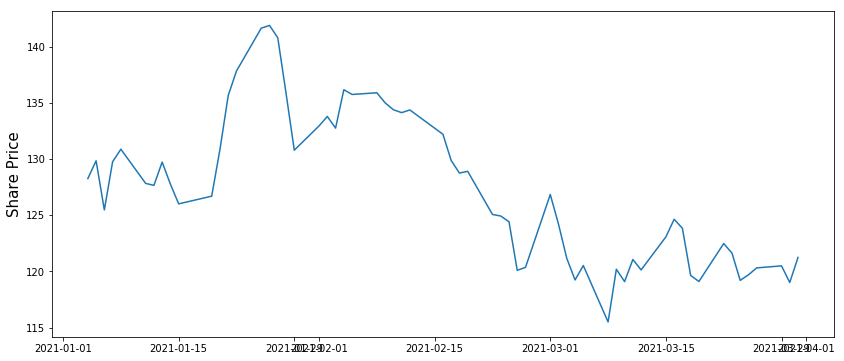

In [154]:
plt.figure(figsize=(14,6))
plt.plot(prices)
plt.ylabel('Share Price', fontsize=15)

## Clearly Prices are not stationary, cannnot fit time series model directly to price data

Text(0, 0.5, 'Daily Return on Apple Share')

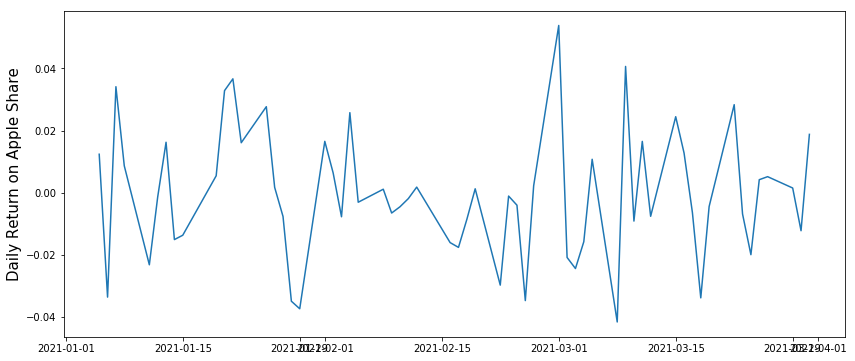

In [155]:
returns = prices.pct_change().dropna()
plt.figure(figsize=(14, 6))
plt.plot(returns)
plt.ylabel("Daily Return on Apple Share", fontsize=15)

### Looks like Stationary, 3 type of Stationary:- 

     1. Trend Stationary
     2. Seasonal Stationary
     3. Strictly Stationary : Joint Distribution of observations

### Augmented Dickey-fuller test (Unit root test)

### Null: Time series data is not stationary
### Alternate: it is stationary

In [156]:
# testing for stationary conditions

from statsmodels.tsa.stattools import adfuller
values = returns.values

res = adfuller(values)

if res[1] > 0.05:
    print("Apple returns are not stationary")
else:
    print("Reject the Null, apple returns are stationary")

Reject the Null, apple returns are stationary


## Fitting the ARMA model in the return series that is already Stationary

### ACF plot will give us number of lags that are to be included as a MA part while PACF plot will give us number of lags that are to be included as a AR part 

In [157]:
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

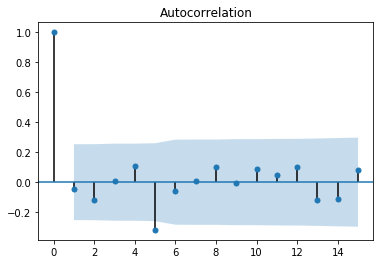

In [158]:
plot_acf(returns, lags=15)
plt.show()

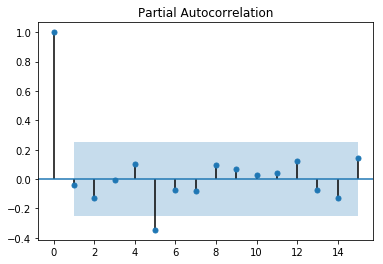

In [159]:
plot_pacf(returns, lags=15)
plt.show()

### Only lag = 5 show a little bit of statistical significance. 

### For the purpose of learning, we will choose lag = 5 for both AR and MA part of fitting ARMA model

## Now we will work on defining a method which will choose to buy or not on any particular day and sell it next day and then try to find whether we can create a strategy around this to generate returns

In [160]:
# for progress bar
from tqdm import tqdm

In [161]:
def run_simulation(prices, returns, amt_invested, order_of_arima, threshold, type_of_strategy):
    if type_of_strategy == 'random':
        threshold = None
        
    curr_holding = False
    events_list = []
    init_amt = amt_invested
    buy_price = prices.loc[returns.index[0]]
    
    for date, r in tqdm(returns.iloc[:].items(), total=len(returns.iloc[:])):
        # get data till this data as only this info is available to make decision
        curr_data = returns[:date]
        
        # if i have bought last day, then i need to sell it today
        if curr_holding:
            sell_price = prices.loc[date]
            print(f"Sell Price is {sell_price}" )
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt_invested *= (1 + ret)
            events_list.append(('s', date, ret))
            
        if type_of_strategy == 'arima':
            try:
                model = ARIMA(curr_data, order=order_of_arima).fit(maxiter=200)
                pred = model.forecast()[0][0] # next day of forecast
            except:
                pred = threshold - 1
        
        # if you pred high positive return and not holding stock, then buy it
        condition_for_random_or_arima = ( (type_of_strategy == 'random' and np.random.random() < order_of_arima) or (type_of_strategy == 'arima' and pred > threshold))
        if (not curr_holding) and condition_for_random_or_arima:
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            print(f"Buy Price is {buy_price}" )
            
    print(f"Total amount of {init_amt} end up as {amt_invested}")
    
    return amt_invested

In [162]:
amt_final = run_simulation(prices, returns, 100, 0.5, 0.001, 'random')

100%|██████████| 60/60 [00:00<00:00, 1430.35it/s]

Buy Price is 129.85081481933594
Sell Price is 125.47985076904297
Buy Price is 129.76162719726562
Sell Price is 130.88165283203125
Buy Price is 130.88165283203125
Sell Price is 127.8387680053711
Buy Price is 127.66039276123047
Sell Price is 129.7318878173828
Buy Price is 129.7318878173828
Sell Price is 127.7694091796875
Buy Price is 126.01508331298828
Sell Price is 126.69896697998047
Buy Price is 126.69896697998047
Sell Price is 130.86180114746094
Buy Price is 130.86180114746094
Sell Price is 135.6589813232422
Buy Price is 140.80307006835938
Sell Price is 135.8770294189453
Buy Price is 132.95314025878906
Sell Price is 133.7956085205078
Buy Price is 132.75489807128906
Sell Price is 136.17437744140625
Buy Price is 135.7525177001953
Sell Price is 135.90139770507812
Buy Price is 135.00802612304688
Sell Price is 134.39260864257812
Buy Price is 134.134521484375
Sell Price is 134.3727569580078
Buy Price is 132.20883178710938
Sell Price is 129.87612915039062
Buy Price is 128.75445556640625
Sell

In [163]:
dt = returns.index[10]
dt
prices

Date
2021-01-04    128.264984
2021-01-05    129.850815
2021-01-06    125.479851
2021-01-07    129.761627
2021-01-08    130.881653
2021-01-11    127.838768
2021-01-12    127.660393
2021-01-13    129.731888
2021-01-14    127.769409
2021-01-15    126.015083
2021-01-19    126.698967
2021-01-20    130.861801
2021-01-21    135.658981
2021-01-22    137.839523
2021-01-25    141.655457
2021-01-26    141.893326
2021-01-27    140.803070
2021-01-28    135.877029
2021-01-29    130.792419
2021-02-01    132.953140
2021-02-02    133.795609
2021-02-03    132.754898
2021-02-04    136.174377
2021-02-05    135.752518
2021-02-08    135.901398
2021-02-09    135.008026
2021-02-10    134.392609
2021-02-11    134.134521
2021-02-12    134.372757
2021-02-16    132.208832
                 ...    
2021-02-18    128.754456
2021-02-19    128.913254
2021-02-22    125.071770
2021-02-23    124.932816
2021-02-24    124.426567
2021-02-25    120.098694
2021-02-26    120.366707
2021-03-01    126.848595
2021-03-02    124.19

In [164]:
sell_price = prices.loc[dt]

In [165]:
sell_price


130.86180114746094

In [166]:
curr_data = returns[:dt]
curr_data

Date
2021-01-05    0.012364
2021-01-06   -0.033661
2021-01-07    0.034123
2021-01-08    0.008631
2021-01-11   -0.023249
2021-01-12   -0.001395
2021-01-13    0.016227
2021-01-14   -0.015127
2021-01-15   -0.013730
2021-01-19    0.005427
2021-01-20    0.032856
Name: Close, dtype: float64

In [168]:
amt_final

92.66044011063171